In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import os
import matplotlib.style
from pandas.core.common import flatten
from functools import partial, reduce

In [2]:
import sys
sys.path.append('../../')

In [3]:
from config.constants import *

In [4]:
plt.style.use('ggplot')

In [5]:
pairs_list = [
    'XAUUSD/XAUUSD_H4 - XAUUSD_H4',
]
  

In [6]:
df = {}
for pair in range(len(pairs_list)):
    df[pair] = pd.read_csv(PATH_DATA + SYMBOL['XAUUSD']['H4'] + '.csv', index_col='Time', parse_dates=True)

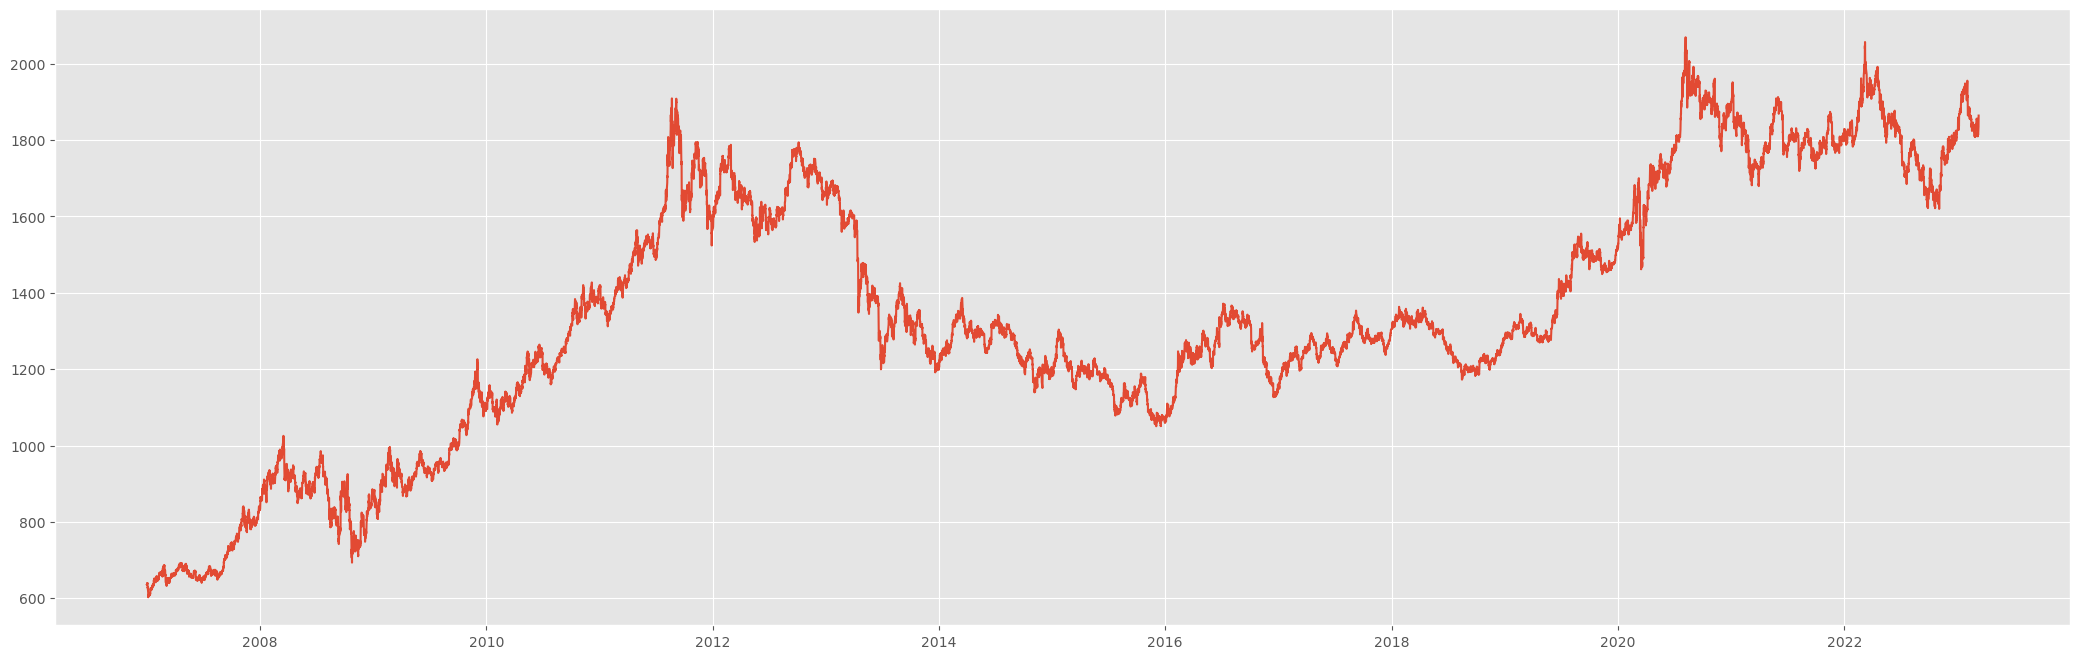

In [7]:
plt.figure(figsize = (26, 8))
plt.plot(df[0]['Close'])

In [8]:
#Strategy parameters
account_size = 1000
slippage = 2
size = 1
ATR_SL = 0.5

In [9]:
def SMA(df, fast, slow):
    df['sma_fast'] = df['Close'].rolling(fast).mean()
    df['sma_slow'] = df['Close'].rolling(slow).mean()
    return df

def ATR(df, n):
    df = df.copy()
    df['High-Low'] = abs(df['High'] - df['Low'])
    df['High-PrevClose'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-PrevClose'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis = 1, skipna = False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df = df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose'], axis = 1)
    return df

def CAGR(df, source_df,TF):
    df = df.copy()
    n = (len(source_df)*TF) / (252*24)
    return round((((df['cum_res'][-1] / account_size)**(1/n)) - 1) * 100, 1)

def sharpe_ratio(df):
    df = df.copy()
    returns = df['cum_res'].pct_change()
    volatility = returns.std() * np.sqrt(252)
    return round((returns.mean() - 0.02) / volatility, 2)

def max_drawdown(df):
    df = df.copy()
    cum_returns = (1 + df['cum_res']).cumprod()
    drawdown = 1 - df['cum_res'].div(df['cum_res'].cummax())
    return round(max(drawdown.expanding().max() * 100), 2)

In [10]:


for pair in range(len(pairs_list)):
    df[pair]['ATR'] = ATR(df[pair], 20)['ATR']
    df[pair]['sma_fast'] = SMA(df[pair], 50, 200)['sma_fast']
    df[pair]['inside_bar'] = np.where(((df[pair]['High'] < df[pair]['High'].shift(1)) & (df[pair]['Low'] > df[pair]['Low'].shift(1))), True, False)
    if 'USDJPY/USDJPY_H4 - USDJPY_H4'  not in pairs_list[pair] and 'XAUUSD/XAUUSD_H4 - XAUUSD_H4'  not in pairs_list[pair] :
        df[pair]['spread'] = float(slippage) / float(10000)
        df[pair]['size'] = float(size) * float(10000)
        print('Pair: ', pairs_list[pair], 'a')

    
    else:
        df[pair]['spread'] = float(slippage) / float(100)
        df[pair]['size'] = float(size) * float(100)
        print('Pair: ', pairs_list[pair], 'b')

Pair:  XAUUSD/XAUUSD_H4 - XAUUSD_H4 b


In [11]:
df[0]

,Open,High,Low,Close,Volume,ATR,sma_fast,sma_slow,inside_bar,spread,size
Time,,,,,,,,,,,
2007-01-01 00:00:00,635.679,636.194,635.009,635.497,95,NaN,NaN,NaN,False,0.02,100.0
2007-01-01 04:00:00,635.336,636.220,635.254,635.699,97,NaN,NaN,NaN,False,0.02,100.0
2007-01-01 08:00:00,635.780,636.225,635.201,635.993,99,NaN,NaN,NaN,False,0.02,100.0
2007-01-01 12:00:00,636.053,636.189,635.117,636.006,90,NaN,NaN,NaN,False,0.02,100.0
2007-01-01 16:00:00,635.902,636.185,635.006,635.989,96,NaN,NaN,NaN,False,0.02,100.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-10 00:00:00,1831.428,1834.765,1827.974,1829.085,240,7.78390,1832.41046,1862.851480,False,0.02,100.0
2023-03-10 04:00:00,1829.085,1834.575,1827.675,1833.405,240,8.04590,1832.78206,1862.333880,False,0.02,100.0
2023-03-10 08:00:00,1833.415,1837.245,1830.778,1834.865,240,8.05175,1833.27226,1861.849780,False,0.02,100.0


In [12]:
open_trade = {}
trade = {}
long_take_profit = {}
short_take_profit = {}
long_stop_loss = {}
short_stop_loss = {}
long_entry_price = {}
short_entry_price = {}

for pair in range(len(pairs_list)):
    open_trade[pair] = []
    trade[pair] = {}
    long_take_profit[pair] = []
    short_take_profit[pair] = []
    long_stop_loss[pair] = []
    short_stop_loss[pair] = []
    long_entry_price[pair] = []
    short_entry_price[pair] = []
    
    for i in range(50, len(df[pair])):
        #Buy
        if df[pair]['inside_bar'][i - 2] == True and df[pair]['inside_bar'][i - 1] == True and df[pair]['sma_fast'][i - 1] >= df[pair]['sma_slow'][i - 1] \
            and df[pair]['Close'][i] > df[pair]['Open'][i] and len(open_trade[pair]) == 0:
            print(i, 'New Long trade at price:', round(df[pair]['Close'][i], 4), ' On day:', df[pair].index[i], 'Pair:', pairs_list[pair])
            trade[pair][i] = {'ID': i,
                             'date_of_trade': df[pair].index[i],
                             'entry_price': df[pair]['Close'][i],
                             'signal': 'Buy',
                             'result': 0, 
                             'TP': df[pair]['Close'][i] + df[pair]['ATR'][i] * ATR_SL,
                             'SL': df[pair]['Close'][i] - df[pair]['ATR'][i] * ATR_SL}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])
        
        #Sell
        if df[pair]['inside_bar'][i - 2] == True and df[pair]['inside_bar'][i - 1] == True and df[pair]['sma_fast'][i - 1] <= df[pair]['sma_slow'][i - 1] \
            and df[pair]['Close'][i] < df[pair]['Open'][i] and len(open_trade[pair]) == 0:
            print(i, 'New Short trade at price:', round(df[pair]['Close'][i], 4), ' On day:', df[pair].index[i], 'Pair:', pairs_list[pair])
            trade[pair][i] = {'ID': i,
                             'date_of_trade': df[pair].index[i],
                             'entry_price': df[pair]['Close'][i],
                             'signal': 'Sell',
                             'result': 0, 
                             'TP': df[pair]['Close'][i] - df[pair]['ATR'][i] * ATR_SL,
                             'SL': df[pair]['Close'][i] + df[pair]['ATR'][i] * ATR_SL}
            open_trade[pair].append(i)
            short_take_profit[pair].append(trade[pair][i]['TP'])
            short_stop_loss[pair].append(trade[pair][i]['SL'])
            short_entry_price[pair].append(trade[pair][i]['entry_price'])
            
        #Exit trades---------------------------------------------------------------------------
        #Buy profit
        if any(y <= df[pair]['Close'][i] for y in long_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if df[pair]['Close'][i] >= trade[pair][j]['TP']:
                        trade[pair][j].update({'result' : (trade[pair][j]['TP'] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Long profit at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Buy loss
        if any(y >= df[pair]['Close'][i] for y in long_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if df[pair]['Close'][i] <= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['SL'] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Long loss at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With loss:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
                        
        #Sell profit
        if any(y >= df[pair]['Close'][i] for y in short_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if df[pair]['Close'][i] <= trade[pair][j]['TP']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['TP'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Short profit at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Sell loss
        if any(y <= df[pair]['Close'][i] for y in short_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if df[pair]['Close'][i] >= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['SL'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Short loss at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With loss:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Exit after time
        if len(open_trade[pair]) != 0:
            for j in open_trade[pair]:
                if (i - trade[pair][j]['ID']) >= 12 and trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    trade[pair][j].update({'result' : (df[pair]['Close'][i] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                    print(j, 
                         'Long exited after 48 hours:', round(df[pair]['Close'][i], 4),
                         'On day:', df[pair].index[i],
                         'With profit:', round(trade[pair][j]['result'], 4), '\n')
                    open_trade[pair].remove(j)
                    long_take_profit[pair].remove(trade[pair][j]['TP'])
                    long_stop_loss[pair].remove(trade[pair][j]['SL'])
                elif (i - trade[pair][j]['ID']) >= 12 and trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - df[pair]['Close'][i] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                    print(j, 
                         'Short exited after 48 hours:', round(df[pair]['Close'][i], 4),
                         'On day:', df[pair].index[i],
                         'With profit:', round(trade[pair][j]['result'], 4), '\n')
                    open_trade[pair].remove(j)
                    short_take_profit[pair].remove(trade[pair][j]['TP'])
                    short_stop_loss[pair].remove(trade[pair][j]['SL'])

247 New Long trade at price: 682.67  On day: 2007-02-25 20:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
247 Long profit at price: 687.055 On day: 2007-02-26 00:00:00 With profit: 242.78 

297 New Long trade at price: 651.347  On day: 2007-03-08 00:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
297 Long loss at price: 648.042 On day: 2007-03-09 16:00:00 With loss: -284.2675 

334 New Short trade at price: 645.595  On day: 2007-03-16 00:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
334 Short loss at price: 650.848 On day: 2007-03-16 08:00:00 With loss: -223.32 

402 New Long trade at price: 664.938  On day: 2007-04-01 20:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
402 Long loss at price: 661.931 On day: 2007-04-02 08:00:00 With loss: -204.9625 

415 New Long trade at price: 664.103  On day: 2007-04-04 00:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
415 Long profit at price: 672.595 On day: 2007-04-04 12:00:00 With profit: 164.765 

458 New Long trade at price: 677.223  On day: 2007-04-13 00:00:00 Pair: XAUUSD

4029 New Short trade at price: 937.629  On day: 2009-06-28 20:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
4029 Short loss at price: 940.823 On day: 2009-06-29 08:00:00 With loss: -275.465 

4072 New Short trade at price: 922.661  On day: 2009-07-07 20:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
4072 Short profit at price: 919.662 On day: 2009-07-08 08:00:00 With profit: 213.4625 

4117 New Short trade at price: 936.021  On day: 2009-07-17 04:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
4117 Short loss at price: 938.234 On day: 2009-07-19 20:00:00 With loss: -194.145 

4222 New Long trade at price: 945.794  On day: 2009-08-11 00:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
4222 Long loss at price: 942.86 On day: 2009-08-12 04:00:00 With loss: -251.625 

4370 New Long trade at price: 1008.144  On day: 2009-09-13 20:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
4370 Long loss at price: 1003.092 On day: 2009-09-14 00:00:00 With loss: -319.535 

4432 New Long trade at price: 994.157  On day: 2009-09-27 20:00:

In [13]:
pairs_results = {}
profits = {}
losses = {}
be = {}

for pair in range(len(pairs_list)):
    profits[pair] = []
    losses[pair] = []
    be[pair] = []
    
    pairs_results[pair] = pd.DataFrame.from_dict({(i, j): trade[pair][j] for j in trade[pair].keys()}, orient = 'index')
    pairs_results[pair] = pairs_results[pair].drop(['signal', 'ID', 'TP', 'SL'], axis = 1)
    pairs_results[pair].set_index('date_of_trade', inplace = True)
    pairs_results[pair]['cum_res'] = pairs_results[pair]['result'].cumsum() + account_size
    
    for t in trade[pair]:
        profits[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] > 0.1 else ''
        losses[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] < -0.1 else ''
        be[pair].append(trade[pair][t]['result']) if -0.1 <= trade[pair][t]['result'] <= 0.1 else ''
        
my_reduce = partial(pd.merge, on = 'date_of_trade', how = 'outer')
strategy_results = reduce(my_reduce, pairs_results.values())
strategy_results = strategy_results.sort_index()
strategy_results['final_res'] = strategy_results.filter(like = 'result', axis = 1).sum(axis = 1)
strategy_results['cum_res'] = strategy_results['final_res'].cumsum() + account_size

profits_keys = list(profits.keys())
profits_values = [profits[x] for x in profits_keys]
str_profits = list(flatten(profits_values))

losses_keys = list(losses.keys())
losses_values = [losses[x] for x in losses_keys]
str_losses = list(flatten(losses_values))

be_keys = list(be.keys())
be_values = [be[x] for x in be_keys]
str_be = list(flatten(be_values))

Text(0.5, 1.0, 'Returns of each pair')

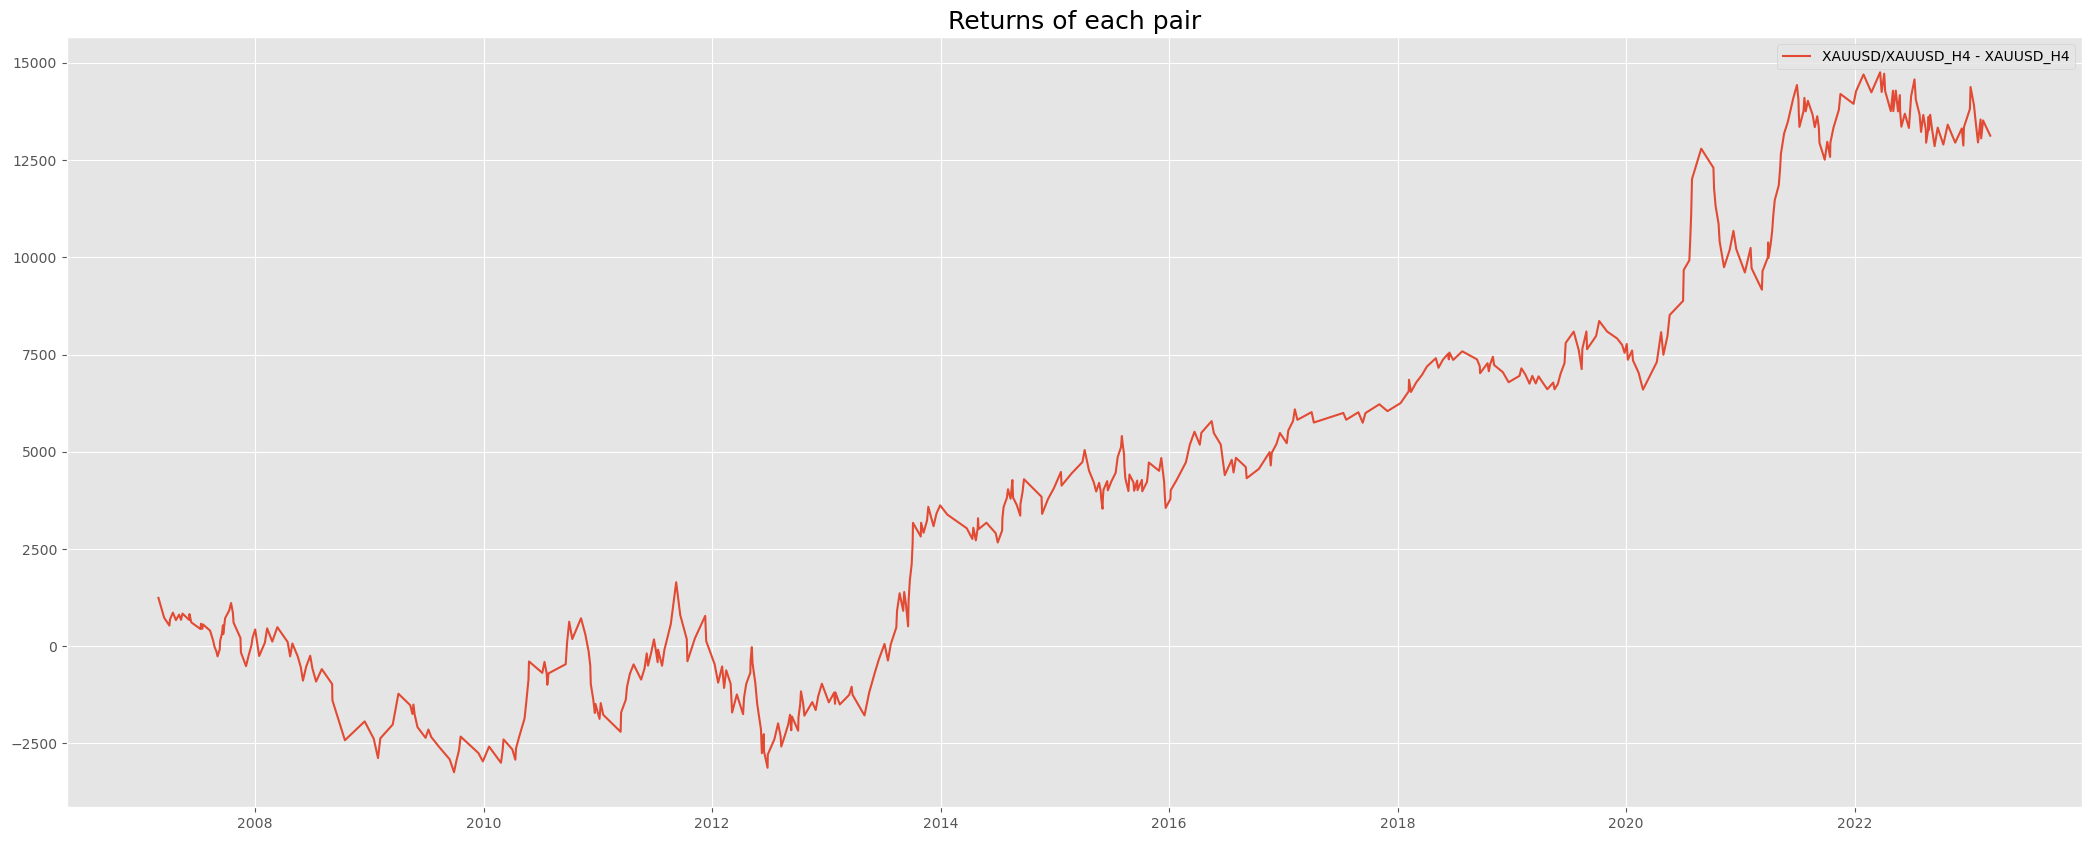

In [14]:
plt.figure(figsize = (26, 10))
for pair in range(len(pairs_list)):
    plt.plot(pairs_results[pair]['cum_res'], label = pairs_list[pair])
plt.legend()
plt.title('Returns of each pair', fontsize = 18)

In [15]:
strategy_results.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 496 entries, 2007-02-25 20:00:00 to 2023-03-10 00:00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   entry_price  496 non-null    float64
 1   result       496 non-null    float64
 2   cum_res      496 non-null    float64
 3   final_res    496 non-null    float64
dtypes: float64(4)
memory usage: 19.4 KB


In [16]:
strategy_results['cum_res']

date_of_trade
2007-02-25 20:00:00     1242.7800
2007-03-08 00:00:00      958.5125
2007-03-16 00:00:00      735.1925
2007-04-01 20:00:00      530.2300
2007-04-04 00:00:00      694.9950
                          ...    
2023-01-29 20:00:00    12951.9225
2023-02-07 00:00:00    13543.0875
2023-02-09 00:00:00    13055.7300
2023-02-15 00:00:00    13517.9100
2023-03-10 00:00:00    13126.7150
Name: cum_res, Length: 496, dtype: float64

***** STRATEGY PERFORMANCE *****
--------------------------------
CAGR: 16.2 %
Sharpe ratio: 0.0
Maximum drawdown 360.77 % 

Number of trades: 496
Number of profits: 266
Number of losses: 230
Number of breakevens: 0 

Winning percentage 53.63 %
ROI: 12127
--------------------------------
Average profitable trade: 347.29
Average lossing trade: -348.92
Max profitable trade: 1072.74
Max lossing trade: -1027.92


c:\Users\Win10\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


Text(0.5, 1.0, 'return of strategy')

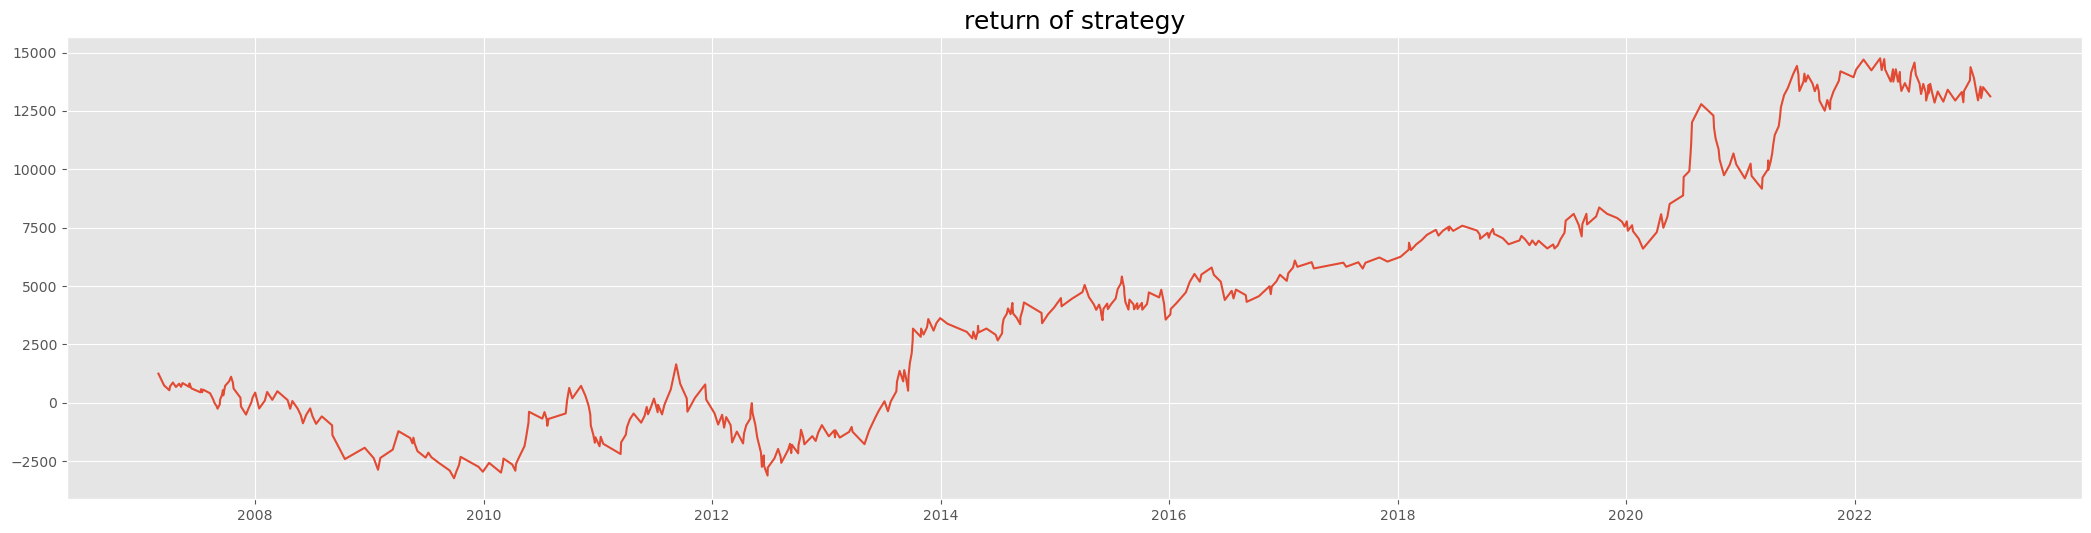

In [17]:
#Strategy performance
print('***** STRATEGY PERFORMANCE *****')
print('--------------------------------')
print('CAGR:', CAGR(strategy_results, df[0],4), '%')
print('Sharpe ratio:', sharpe_ratio(strategy_results))
print('Maximum drawdown', max_drawdown(strategy_results), '% \n')
print('Number of trades:', len(str_profits + str_losses + str_be))
print('Number of profits:', len(str_profits))
print('Number of losses:', len(str_losses))
print('Number of breakevens:', len(str_be), '\n')
print('Winning percentage', (round(len(str_profits) / (len(str_profits) + len(str_losses)) * 100, 2)), '%')
print('ROI:', round(strategy_results['cum_res'][-1]) - account_size)
print('--------------------------------')
print('Average profitable trade:', round(sum(str_profits) / len(str_profits), 2))
print('Average lossing trade:', round(sum(str_losses) / len(str_losses), 2))
print('Max profitable trade:', round(max(str_profits), 2))
print('Max lossing trade:', round(min(str_losses), 2))

plt.figure(figsize = (26, 6))
plt.plot(strategy_results['cum_res'])
plt.title('return of strategy', fontsize = 18)